In [1]:
#%% import
import os
os.chdir('../../')
import ast
import os
import shutil
import numpy as np 
import pandas as pd
import os
from os import path
from glob import glob
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import shutil

In [2]:
#%% set label dictionary and params
classfiles = os.listdir('Data/')
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)} #adds underscores

num_classes = 100    #340 max 
imheight, imwidth = 64, 64  
ims_per_class = 4000  #max?

In [3]:
def Create_Testset(directory, classes):
    destination = 'Data/'+str(classes)+'_Categories/testset' 
    exists = os.path.exists(destination)
    
    if not exists:
        os.makedirs(destination)

    for filename in os.listdir(directory):
        df = pd.read_csv(directory+filename)
        df2 = df.tail(100)

        row_count, dummy = df.shape
        if row_count > 20000:
            df.drop(df.tail(100).index,inplace = True)
            df.to_csv(directory+filename, index=False)

        df2.to_csv("Data/"+str(classes)+"_categories/testset/"+filename, mode='w', index=False)

def splitData(amount):
    source = 'Data/Complete_Data_Filtered/'              
    destination = 'Data/'+str(amount)+'_Categories/trainset/' 
    exists = os.path.exists(destination)
    
    if not exists:
        os.makedirs(destination)

    folders = os.listdir(source)               

    for folder in folders[:amount+2]:                                           
        file = folder                  
        curr_file = source + file    
        shutil.copy(curr_file, destination) 
    
    directory = "Data/"+str(amount)+"_Categories/trainset/"
    Create_Testset(directory, amount)

In [4]:
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

def trainArray(path, num_classes, ims_per_class):
    path = path+"trainset/*.csv"
    train_grand = []
    class_paths = glob(path)
    for i,c in enumerate(tqdm(class_paths[0: num_classes])):
        train = pd.read_csv(c, usecols=['drawing'], nrows=ims_per_class*5//4).head(ims_per_class)
        imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
        trainarray = np.array(imagebag.compute())  # PARALLELIZE
        trainarray = np.reshape(trainarray, (ims_per_class, -1))    
        labelarray = np.full((train.shape[0], 1), i)
        trainarray = np.concatenate((labelarray, trainarray), axis=1)
        train_grand.append(trainarray)
        
    train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
    train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

    del trainarray
    del train
    return train_grand

def testArray(path, num_classes, ims_per_class):
    path = path+"testset/*.csv"
    test_grand = []
    class_paths = glob(path)
    for i,c in enumerate(tqdm(class_paths[0: num_classes])):
        test = pd.read_csv(c, usecols=['drawing'], nrows=ims_per_class*5//4).head(ims_per_class)
        imagebag = bag.from_sequence(test.drawing.values).map(draw_it) 
        testarray = np.array(imagebag.compute())  # PARALLELIZE
        testarray = np.reshape(testarray, (ims_per_class, -1))    
        labelarray = np.full((test.shape[0], 1), i)
        testarray = np.concatenate((labelarray, testarray), axis=1)
        test_grand.append(testarray)
        
    test_grand = np.array([test_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
    test_grand = test_grand.reshape((-1, (imheight*imwidth+1)))

    del testarray
    del test
    return test_grand

In [5]:
def SplitData(train_grand, test_grand, num_classes):
    # memory-friendly alternative to train_test_split
    valfrac = 0.15
    cutpt = int(valfrac * train_grand.shape[0])

    np.random.shuffle(train_grand)
    y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
    y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:]
    y_test, X_test = test_grand[0: , 0], test_grand[0: , 1:]

    y_train = keras.utils.to_categorical(y_train, num_classes)
    X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)

    y_val = keras.utils.to_categorical(y_val, num_classes)
    X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

    y_test = keras.utils.to_categorical(y_test, num_classes)
    X_test = X_test.reshape(X_test.shape[0], imheight, imwidth, 1)

    return y_train, X_train, y_val, X_val, y_test, X_test

In [6]:
def model(classes):
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ])

    inputs = keras.Input(shape=(64,64,1))

    x = layers.Conv2D(filters=16, kernel_size=3, padding='same', activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = layers.Dropout(0.15)(x)

    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = layers.Dropout(0.15)(x)

    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = layers.Dropout(0.15)(x)

    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = layers.Dropout(0.15)(x)

    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = layers.Dropout(0.15)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
splitData(num_classes)

In [8]:
path = 'Data/'+str(num_classes)+'_Categories/'

TrainArray = trainArray(path, num_classes, ims_per_class)
TestArray = testArray(path, num_classes, 100)

y_train, X_train, y_val, X_val, y_test, X_test = SplitData(TrainArray, TestArray, num_classes)

100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


In [9]:
model = model(num_classes)

In [10]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="models/"+str(num_classes)+"_Categories_Model.h5", save_best_only=True, monitor="val_loss"),keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    ]

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train,
          batch_size = 256,
          epochs = 100,
          validation_data = (X_val, y_val),
          callbacks = callbacks)

Epoch 1/100
1329/1329 [==============================] - 53s 38ms/step - loss: 3.9335 - accuracy: 0.1039 - val_loss: 3.1319 - val_accuracy: 0.2801
Epoch 2/100
1329/1329 [==============================] - 48s 36ms/step - loss: 2.8291 - accuracy: 0.2965 - val_loss: 2.2642 - val_accuracy: 0.4380
Epoch 3/100
1329/1329 [==============================] - 48s 36ms/step - loss: 2.2576 - accuracy: 0.4153 - val_loss: 1.8906 - val_accuracy: 0.5147
Epoch 4/100
1329/1329 [==============================] - 48s 36ms/step - loss: 1.9386 - accuracy: 0.4873 - val_loss: 1.6486 - val_accuracy: 0.5667
Epoch 5/100
1329/1329 [==============================] - 48s 36ms/step - loss: 1.7165 - accuracy: 0.5384 - val_loss: 1.3654 - val_accuracy: 0.6340
Epoch 6/100
1329/1329 [==============================] - 

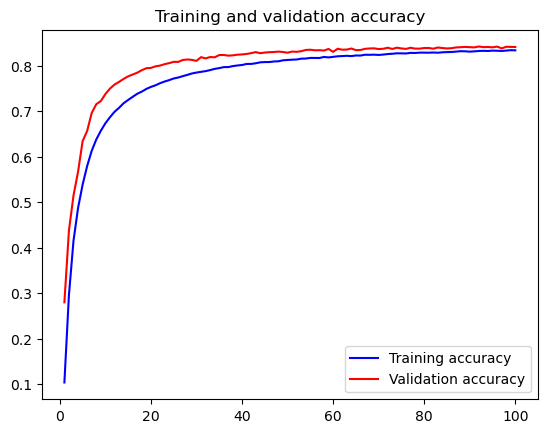

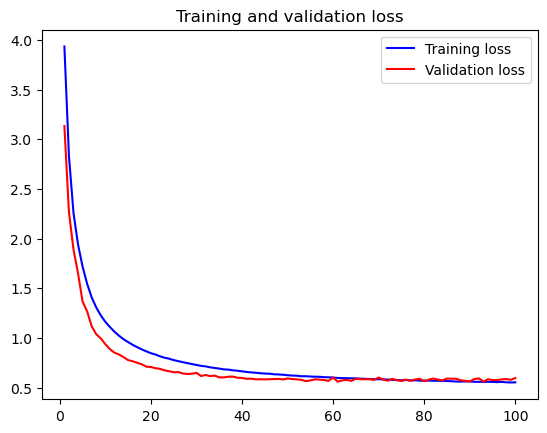

In [11]:
def plot_function(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

plot_function(history)

In [12]:
test_model = keras.models.load_model("models/100_Categories_Model.h5")
test_loss, test_acc = test_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.5646 - accuracy: 0.8324
Test accuracy: 0.832
